In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/RL Finance

/content/drive/MyDrive/Colab Notebooks/RL Finance


In [ ]:
# package imports
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
import time
from collections import deque
from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import Dense, Dropout
from keras.models import Sequential

In [ ]:
# In this notebook, we improve the environment and agent to handle trading multiple stocks at the same time
# This allows for a larger state space and action space

In [ ]:
def set_seeds(seed=100):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  learn_env.seed(seed) #setting seed for the env that we eventually build
  learn_env.action_space.seed(seed)
  valid_env.seed(seed)
  valid_env.action_space.seed(seed)

In [ ]:
# We start by building the same prediction game env as in Hilpsich's lectures.
# In the next notebooks, we will improve it to accommodate more sophisticated asset allocation algorithms
class observation_space:
  ''' only one parameter, the last n days' observations '''
  def __init__(self, n):
    self.shape = (n,)

class action_space:
  ''' buy or sell decisions, n=2^k where k is the number of stocks we are interested in '''
  def __init__(self, n):
    self.n = n
  def seed(self, seed):
    random.seed(seed)
  def sample(self):
    return random.randint(0, self.n-1)

In [ ]:
# env class in the Hilpisch style, but allowing for multiple symbols and multiple features for each

class FinEnv:
    datapath = '/content/drive/MyDrive/Colab Notebooks/RL Finance/aiif_eikon_eod_data.csv'
    def __init__(self, symbols, features, window, lags,
                 leverage=1, min_performance=0.85,
                 start=0, end=None, mu=None, std=None, setup=True):
        self.symbols = symbols
        self.n_symbols = len(symbols)
        # setup the features
        self.features = []
        for symbol in symbols:
          for feature in features:
            self.features.append(feature+'_'+symbol)
        self.n_features = len(self.features)
        self.window = window
        self.lags = lags
        self.leverage = leverage
        self.min_performance = min_performance # performance below which the agent "loses the game"
        self.start = start # where to start and end the dataset, this will be used to split the dataset into training and validation
        self.end = end
        self.mu = mu # what numbers to use to normalize, we want to normalize the validation dataset with the same parameters as the training
        self.std = std
        self.observation_space = observation_space(self.lags)
        self.action_space = action_space(2**(self.n_symbols)) # up or down for each symbol
        if setup: #set to False for debugging data related issues
          self._get_data()
          self._prepare_data()
    def _get_data(self):
        self.raw = pd.read_csv(self.datapath, index_col=0,
                               parse_dates=True).dropna()
    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbols])
        self.data = self.data.iloc[self.start:]
        for symbol in self.symbols:
          self.data['r_'+symbol] = np.log(self.data[symbol] / self.data[symbol].shift(1)) # log returns
          self.data.dropna(inplace=True)
          self.data['s_'+symbol] = self.data[symbol].rolling(
                                                self.window).mean() # momentum of the prices
          self.data['m_'+symbol] = self.data['r_'+symbol].rolling(self.window).mean() # momentum of the returns
          self.data['v_'+symbol] = self.data['r_'+symbol].rolling(self.window).std() # volatility of the returns
          self.data.dropna(inplace=True)
        if self.mu is None:
              self.mu = self.data.mean()
              self.std = self.data.std()
        self.data_ = (self.data - self.mu) / self.std
        for symbol in self.symbols:
          self.data_['d_'+symbol] = np.where(self.data['r_'+symbol] > 0, 1, 0)
          self.data_['d_'+symbol] = self.data_['d_'+symbol].astype(int)
        if self.end is not None:
            self.data = self.data.iloc[:self.end - self.start]
            self.data_ = self.data_.iloc[:self.end - self.start]
    def _get_state(self):
        return self.data_[self.features].iloc[self.bar -
                                self.lags:self.bar]
    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.performance = 1
        self.bar = self.lags
        state = self.data_[self.features].iloc[self.bar-
                        self.lags:self.bar]
        return state.values
    def step(self, action):
        # first we decode the action to up-down decisions for each symbol
        actions = [int(x) for x in bin(action)[2:].zfill(self.n_symbols)]
        reward_1 = 0
        reward_2 = 0
        for i,symbol in enumerate(self.symbols):
          correct = actions[i] == self.data_['d_'+symbol].iloc[self.bar]
          reward_1 = reward_1 + (1 if correct else 0)
          ret = self.data['r_'+symbol].iloc[self.bar] * self.leverage
          reward_2 = reward_2 + (abs(ret) if correct else -abs(ret)) # actual returns obtained by taking a position corresponding to the guess

        self.treward += reward_1
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.lags)
        self.performance *= math.exp(reward_2) # because returns are the log returns
        if self.bar >= len(self.data):
            done = True
        elif reward_1 == self.n_symbols: # all guesses was right, keep going
            done = False
        elif (self.performance < self.min_performance and
              self.bar > self.lags + 15): # if performance is terrible after even after the first 15 days, lose
                                          # That is, we allow for bad guesses as long as performance isn't too bad, allowing for exploration
            done = True
        else: # did not lose, continue
            done = False
        state = self._get_state()
        return state.values, reward_1 + reward_2 * 252, done #annualize the returns reward

In [ ]:
# demonstrate the env
env = FinEnv(symbols=["AAPL.O", "MSFT.O"], features=['r', 'm', 'v'], window=10, lags=4)
# AAPL stock, returns, momentum and vol as features, features calculated over 10 day windows, 4 days of features representing the observation space everyday.

In [ ]:
env.reset() #should see the first four (normalized) returns, momentum and vol for AAPL and MSFT in the dataset

array([[ 0.2991508 , -2.02364279,  1.80170832,  0.07485765, -2.39774447,
         0.76355174],
       [ 0.99567425, -1.38057691,  1.96274654,  0.36802024, -1.82843072,
         0.81583951],
       [-2.32603392, -1.76134076,  2.17778664, -2.00240999, -2.05466818,
         0.95535665],
       [ 1.02904839, -0.41031486,  1.70355841,  0.40218858, -0.99765452,
         0.57550126]])

In [ ]:
a = env.action_space.sample() #randomly sample 1(up) or 0(down) for each asset in symbol space (AAPL and MSFT)
env.step(a) #we predict "a" happens in the future and see what happens

(array([[ 0.99567425, -1.38057691,  1.96274654,  0.36802024, -1.82843072,
          0.81583951],
        [-2.32603392, -1.76134076,  2.17778664, -2.00240999, -2.05466818,
          0.95535665],
        [ 1.02904839, -0.41031486,  1.70355841,  0.40218858, -0.99765452,
          0.57550126],
        [-0.48335509, -1.0702562 ,  1.43534377, -0.79983672, -1.57865486,
          0.44430138]]),
 -4.446186434129881,
 False)

In [ ]:
# demonstrate an episode where we just flip a coin and predict up vs down
# expect this to be very poor
done = False
env.reset()
while not done:
  a = env.action_space.sample()
  next_state, reward, done = env.step(a)
print('Steps survived: {}, Accuracy: {}, Performance: {}'.format(env.treward, env.accuracy, env.performance))

Steps survived: 17, Accuracy: 0.7727272727272727, Performance: 0.8457132048699403


In [ ]:
# Build a DQN agent to do this
# Framework similar to Hilpsich with fixed targets and experience replay
# This time, we will predict the direction for multiple stocks

In [ ]:
class DQLAgent:
    def __init__(self, gamma, batch_size, hidden_units, n_actions, learning_rate,
                 learn_env, valid_env,
                 update_target_every, dropout=True):
        self.learn_env = learn_env
        self.valid_env = valid_env
        self.dropout = dropout # set some dropout for all the DNNs
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.98
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.batch_size = batch_size
        self.max_treward = 0
        self.trewards = list()
        self.averages = list()
        self.performances = list()
        self.aperformances = list()
        self.vperformances = list()
        self.memory = deque(maxlen=2000)
        self.update_target_every = update_target_every
        self.model = self._build_model(n_actions, hidden_units, learning_rate)
        self.model_target = self._build_model(n_actions, hidden_units, learning_rate)

    def _build_model(self, n_out, hu, lr):
        model = Sequential()
        model.add(Dense(hu, input_shape=(
            self.learn_env.lags, self.learn_env.n_features),
                        activation='relu'))
        if self.dropout:
            model.add(Dropout(0.3, seed=100))
        model.add(Dense(int(hu/2), input_shape=(
            self.learn_env.lags, self.learn_env.n_features),
                    activation='relu'))
        if self.dropout:
            model.add(Dropout(0.3, seed=100))
        model.add(Dense(n_out, activation='linear'))
        model.compile(
            loss='mse',
            optimizer=keras.optimizers.Adam(learning_rate=lr)
        )
        return model

    def act(self, state):
        if random.random() <= self.epsilon:
            return self.learn_env.action_space.sample()
        action = self.model.predict(state, verbose=False)[0, 0]
        return np.argmax(action)

    def replay(self, update_target=False):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model_target.predict(next_state, verbose=False)[0, 0])
            target = self.model_target.predict(state, verbose=False)
            target[0, 0, action] = reward
            self.model.fit(state, target, epochs=1,
                           verbose=False)
        if update_target:
          self.model_target.set_weights(self.model.get_weights())
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state = self.learn_env.reset()
            state = np.reshape(state, [1, self.learn_env.lags,
                                       self.learn_env.n_features])
            for j in range(5000):
                action = self.act(state)
                next_state, reward, done = \
                                self.learn_env.step(action)
                next_state = np.reshape(next_state,
                                [1, self.learn_env.lags,
                                 self.learn_env.n_features])
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state
                if done:
                    treward = j + 1
                    self.trewards.append(treward)
                    av = sum(self.trewards[-25:]) / 25
                    perf = self.learn_env.performance
                    self.averages.append(av)
                    self.performances.append(perf)
                    self.aperformances.append(
                        sum(self.performances[-25:]) / 25)
                    self.max_treward = max(self.max_treward, treward)
                    templ = '\r episode: {:2d}/{} | treward: {:4d} | '
                    templ += 'perf: {:5.3f} | av: {:5.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, perf,
                                  av, self.max_treward), end=' ')
                    break
            if e%20 == 0:
              # validate after every 20 episodes
              self.validate(e, episodes)
            if len(self.memory) > self.batch_size:
                update_target = j%self.update_target_every == 0
                self.replay(update_target)
    def validate(self, e, episodes):
        state = self.valid_env.reset()
        state = np.reshape(state, [1, self.valid_env.lags,
                                   self.valid_env.n_features])
        for _ in range(5000):
            action = np.argmax(self.model.predict(state, verbose=False)[0, 0])
            next_state, reward, done = self.valid_env.step(action)
            state = np.reshape(next_state, [1, self.valid_env.lags,
                                   self.valid_env.n_features])
            if done:
                treward = _ + 1
                perf = self.valid_env.performance
                self.vperformances.append(perf)
                templ = '\n' + 71 * '='
                templ += '\nepisode: {:2d}/{} | VALIDATION | '
                templ += 'treward: {:4d} | perf: {:5.3f} | '
                templ += 'eps: {:.2f}\n'
                templ += 71 * '='
                print(templ.format(e, episodes, treward,
                                    perf, self.epsilon))
                break

In [ ]:
symbols = ['AAPL.O', 'MSFT.O']
features = ['r', 'm', 'v']
train_start = 0
train_end = 2000
validation_size = 500

In [ ]:
# create the learning environment
learn_env = FinEnv(symbols, features, window=10, lags=6,
                 leverage=1, min_performance=0.85,
                 start=train_start, end=train_start+train_end, mu=None, std=None)
# create the validation environment with the same params as the learning env
valid_env = FinEnv(symbols, features, window=learn_env.window,
                 lags=learn_env.lags, leverage=learn_env.leverage,
                 min_performance=learn_env.min_performance,
                 start=train_start+train_end, end=train_start+train_end+validation_size,
                 mu=learn_env.mu, std=learn_env.std)

In [ ]:
set_seeds(100)
agent = DQLAgent(gamma=0.95, batch_size=64, hidden_units=64, n_actions=learn_env.action_space.n, learning_rate=0.001, learn_env=learn_env, valid_env=valid_env, update_target_every=100, dropout=True)

In [ ]:
episodes = 100
%time agent.learn(episodes)

 episode: 20/100 | treward: 1994 | perf: 14.220 | av: 456.8 | max: 1994 
episode: 20/100 | VALIDATION | treward:   44 | perf: 0.811 | eps: 0.70
 episode: 40/100 | treward: 1994 | perf: 10.068 | av: 1179.2 | max: 1994 
episode: 40/100 | VALIDATION | treward:  233 | perf: 0.838 | eps: 0.46
 episode: 60/100 | treward: 1994 | perf: 13.942 | av: 1759.8 | max: 1994 
episode: 60/100 | VALIDATION | treward:  233 | perf: 0.833 | eps: 0.31
 episode: 80/100 | treward: 1994 | perf: 55.772 | av: 1802.4 | max: 1994 
episode: 80/100 | VALIDATION | treward:  490 | perf: 2.840 | eps: 0.21
 episode: 100/100 | treward: 1994 | perf: 21.354 | av: 1843.7 | max: 1994 
episode: 100/100 | VALIDATION | treward:  490 | perf: 4.120 | eps: 0.14
CPU times: user 2h 35min 37s, sys: 2min 43s, total: 2h 38min 21s
Wall time: 2h 39min 55s


In [ ]:
# How much exploration do we have left?
agent.epsilon

0.13532607744362551

In [ ]:
# Still a lot of exploration left
# Let us train for just another 20 episodes - we can check if the validation performance dips due to overfitting because of these extra 20 episodes.

In [17]:
%time agent.learn(episodes=20)

 episode: 20/20 | treward: 1994 | perf: 23.585 | av: 1919.7 | max: 1994 
episode: 20/20 | VALIDATION | treward:  234 | perf: 0.821 | eps: 0.10
CPU times: user 57min 49s, sys: 52.6 s, total: 58min 41s
Wall time: 59min 14s


In [18]:
# How much exploration left?
agent.epsilon

0.09994765958206091

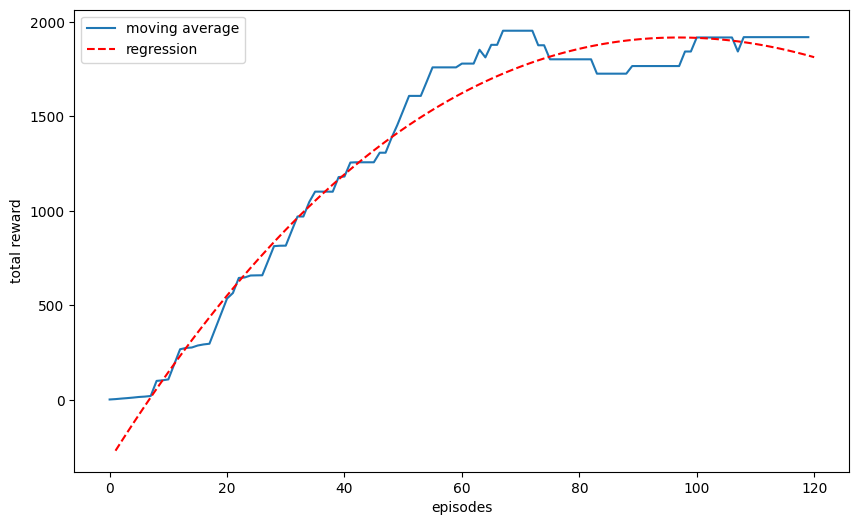

In [19]:
# Plot the learning curve, training "correctness"
plt.figure(figsize=(10, 6))
x = range(1, len(agent.averages) + 1)
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend()

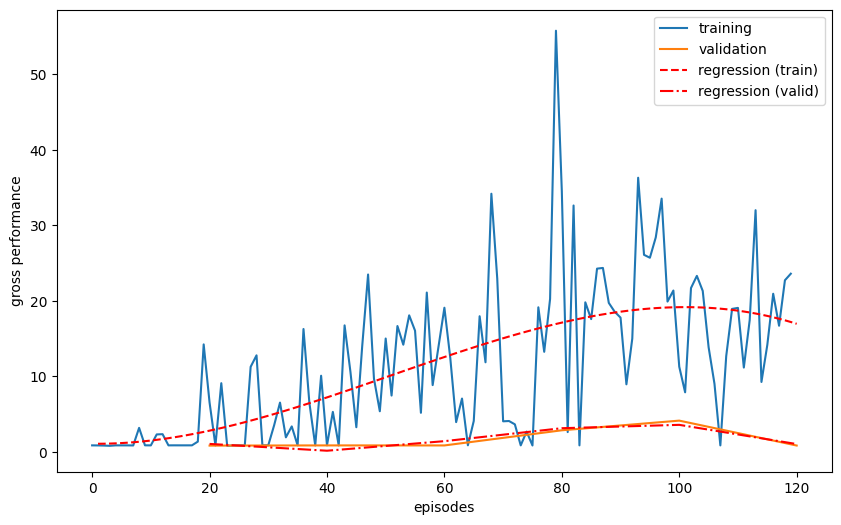

In [20]:
plt.figure(figsize=(10, 6))
x = range(1, len(agent.performances) + 1)
x_ = [20*i for i in range(1, len(agent.vperformances) + 1)]
y = np.polyval(np.polyfit(x, agent.performances, deg=3), x)
y_ = np.polyval(np.polyfit(x_, agent.vperformances, deg=3), x_)
plt.plot(agent.performances[:], label='training')
plt.plot(x_, agent.vperformances[:], label='validation')
plt.plot(x, y, 'r--', label='regression (train)')
plt.plot(x_, y_, 'r-.', label='regression (valid)')
plt.xlabel('episodes')
plt.ylabel('gross performance')
plt.legend()

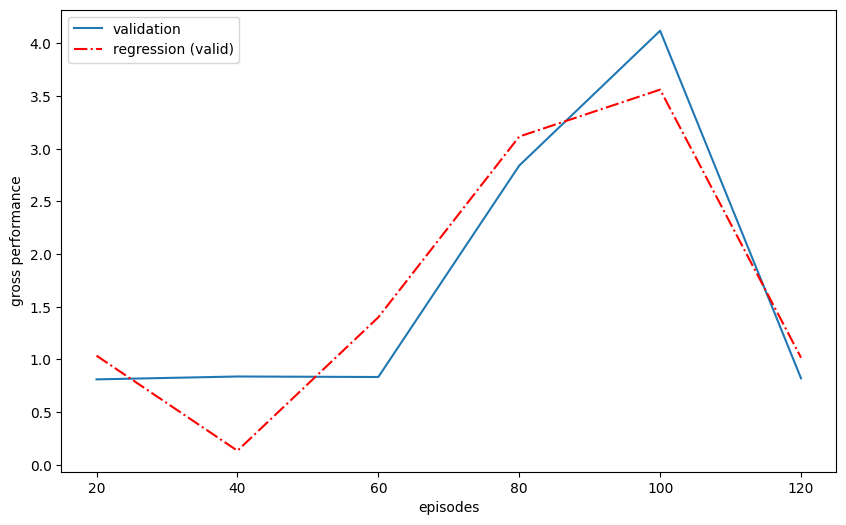

In [21]:
plt.figure(figsize=(10, 6))
x_ = [20*i for i in range(1, len(agent.vperformances) + 1)]
y_ = np.polyval(np.polyfit(x_, agent.vperformances, deg=3), x_)
plt.plot(x_, agent.vperformances[:], label='validation')
plt.plot(x_, y_, 'r-.', label='regression (valid)')
plt.xlabel('episodes')
plt.ylabel('gross performance')
plt.legend()